In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

FAST_MODEL = False

CSV_DIR = '../results/gpu'
all_files = [os.path.join(CSV_DIR, file) for file in os.listdir(CSV_DIR)]
df_list = [pd.read_csv(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

df = df.loc[df['3mm'] == FAST_MODEL]
df['rank_factor'] = df['rank_factor'].astype(str).astype('category')
df['rank_factor'] = df['rank_factor'].cat.add_categories(['Original'])
df.loc[df['apply_tucker'] == False, 'rank_factor'] = 'Original'
new_order = ['Original', '0.9', '0.7', '0.5', '0.4', '0.3', '0.2', '0.1', '0.05']
df['rank_factor'] = df['rank_factor'].cat.reorder_categories(new_order, ordered=True)

df['device_name'] = df['device_name'].astype('category')
new_labels = {
    'NVIDIA GeForce RTX 3090': 'RTX 3090', 
    'NVIDIA GeForce GTX 1080': 'GTX 1080', 
    'NVIDIA A100-SXM4-40GB': 'A100', 
    'NVIDIA GeForce RTX 3060': 'RTX 3060', 
    'NVIDIA GeForce GTX 1660': 'GTX 1660', 
    'NVIDIA RTX A6000': 'A6000', 
    'GeForce RTX 2080 Ti': 'RTX 2080 Ti', 
    'NVIDIA GeForce RTX 2070 SUPER': 'RTX 2070 SUPER', 
}
df['device_name'] = df['device_name'].cat.rename_categories(new_labels)
new_order = ['GTX 1080', 'GTX 1660', 'RTX 2070 SUPER', 'RTX 2080 Ti', 'RTX 3060', 'RTX 3090', 'A6000', 'A100']
df['device_name'] = df['device_name'].cat.reorder_categories(new_order, ordered=True)

df.head()

,batch_size,device,load_params,apply_tucker,autocast,compile,eval_passes,ckpt_path,save_model,load_model,...,rank_mode,rank_factor,rank_min,decompose,verbose,g_flops,m_params,exec_time_mean,exec_time_std,device_name
1,1,cuda,False,True,True,True,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,24.005427,0.257926,16.224461,0.170307,RTX 3090
3,1,cuda,False,True,True,False,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,24.005427,0.257926,21.449270,0.074873,RTX 3090
5,1,cuda,False,True,False,True,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,24.005427,0.257926,19.751299,0.132450,RTX 3090
7,1,cuda,False,True,False,False,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,24.005427,0.257926,27.255786,0.023403,RTX 3090
9,1,cuda,False,False,True,True,10,.checkpoints/model.ckpt,False,False,...,relative,Original,8,False,False,480.561144,31.194809,28.019610,0.417619,RTX 3090


### GPU Variations

In [2]:
df['device_name'].unique()

['RTX 3090', 'GTX 1080', 'A100', 'RTX 3060', 'GTX 1660', 'A6000', 'RTX 2080 Ti', 'RTX 2070 SUPER']
Categories (8, object): ['GTX 1080' < 'GTX 1660' < 'RTX 2070 SUPER' < 'RTX 2080 Ti' < 'RTX 3060' < 'RTX 3090' < 'A6000' < 'A100']

### Execution times

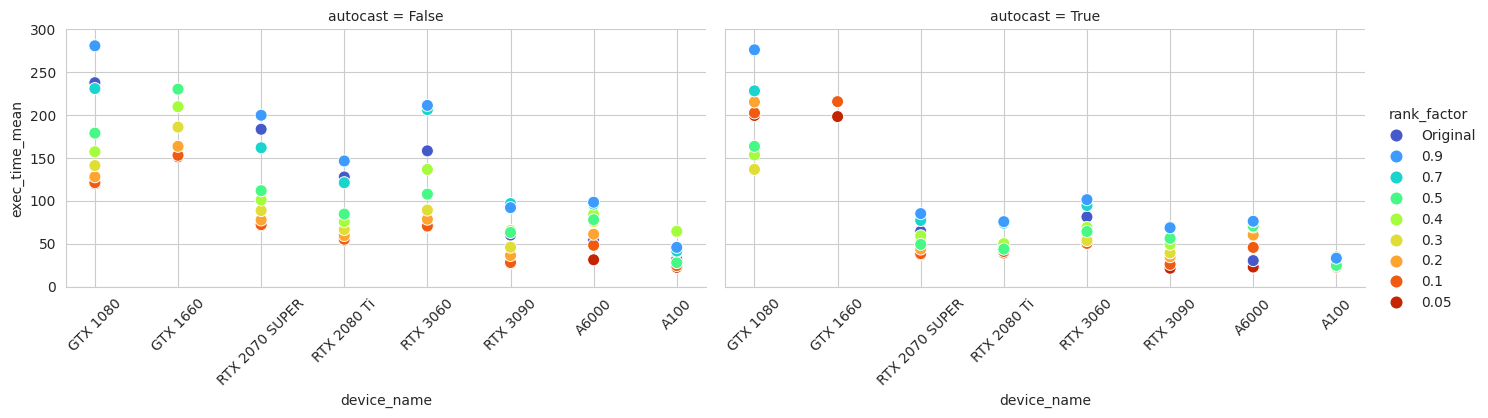

In [3]:
df_sub = df[df['batch_size'] == 1]
df_sub = df_sub[df_sub['compile'] == False]

g = sns.relplot(
    data=df_sub,
    x='device_name',
    y='exec_time_mean',
    hue='rank_factor',
    col='autocast',
    palette='turbo',
    alpha=1,
    height=3.5,
    aspect=2,
    s=75
)

g.set(ylim=(0, 300))

for ax in g.axes.flatten():
    ax.set_xticks(range(len(new_order)))
    ax.set_xticklabels(labels=new_order, rotation=45)
    
plt.show()

In [4]:
df_sub['exec_time_print'] = df_sub.apply(lambda row: f"{row['exec_time_mean']:.2f} $\pm$ {row['exec_time_std']:.2f}", axis=1)

print(df_sub.columns)
print(df_sub.head())
print(len(df_sub))

Index(['batch_size', 'device', 'load_params', 'apply_tucker', 'autocast',
       'compile', 'eval_passes', 'ckpt_path', 'save_model', 'load_model',
       '3mm', 'patch_size', 'nnunet_path', 'rank_mode', 'rank_factor',
       'rank_min', 'decompose', 'verbose', 'g_flops', 'm_params',
       'exec_time_mean', 'exec_time_std', 'device_name', 'exec_time_print'],
      dtype='object')
     batch_size device  load_params  apply_tucker  autocast  compile  \
3             1   cuda        False          True      True    False   
7             1   cuda        False          True     False    False   
11            1   cuda        False         False      True    False   
15            1   cuda        False         False     False    False   
160           1   cuda        False          True      True    False   

     eval_passes                ckpt_path  save_model  load_model  ...  \
3             10  .checkpoints/model.ckpt       False       False  ...   
7             10  .checkpoints/mode

In [5]:
pivot_df = df_sub.pivot_table(index=['autocast', 'rank_factor'], 
                        columns='device_name', 
                        values='exec_time_print',
                        aggfunc=lambda x: ' '.join(x)
).reset_index()

print(pivot_df.head())
pivot_df.to_latex('gpu_bench.tex', index=False)

device_name  autocast rank_factor           GTX 1080           GTX 1660  \
0               False    Original  237.71 $\pm$ 1.31  345.89 $\pm$ 0.27   
1               False         0.9  280.73 $\pm$ 0.99  385.09 $\pm$ 0.35   
2               False         0.7  230.86 $\pm$ 0.86  317.79 $\pm$ 0.54   
3               False         0.5  178.95 $\pm$ 0.44  230.23 $\pm$ 0.40   
4               False         0.4  157.26 $\pm$ 0.19  209.77 $\pm$ 0.29   

device_name     RTX 2070 SUPER        RTX 2080 Ti           RTX 3060  \
0            183.46 $\pm$ 0.33  127.82 $\pm$ 0.51  158.31 $\pm$ 0.23   
1            199.77 $\pm$ 0.41  146.50 $\pm$ 0.24  211.25 $\pm$ 0.36   
2            161.92 $\pm$ 0.20  121.17 $\pm$ 0.69  206.28 $\pm$ 0.24   
3            111.86 $\pm$ 0.13   84.60 $\pm$ 0.45  107.86 $\pm$ 1.25   
4            101.05 $\pm$ 0.22   75.80 $\pm$ 0.22  136.60 $\pm$ 1.92   

device_name          RTX 3090             A6000              A100  
0            60.13 $\pm$ 0.01  54.25 $\pm$ 0.13 

/tmp/ipykernel_22479/3207908652.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df_sub.pivot_table(index=['autocast', 'rank_factor'],
